In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

FILTERED_REGION_CODES = ['AS', 'GU', 'PR', 'VI', 'MP']

%config InlineBackend.figure_format = 'retina'

## Bettencourt & Ribeiro's Approach

Every day, we learn how many more people have COVID-19. This new case count gives us a clue about the current value of $R_t$. We also, figure that the value of $R_t$ today is related to the value of $R_{t-1}$ (yesterday's value) and every previous value of $R_{t-m}$ for that matter.

With these insights, the authors use [Bayes' rule](https://en.wikipedia.org/wiki/Bayes%27_theorem) to update their beliefs about the true value of $R_t$ based on how many new cases have been reported each day.

This is Bayes' Theorem as we'll use it:

$$ P(R_t|k)=\frac{P(k|R_t)\cdot P(R_t)}{P(k)} $$

This says that, having seen $k$ new cases, we believe the distribution of $R_t$ is equal to:

- The __likelihood__ of seeing $k$ new cases given $R_t$ times ...
- The __prior__ beliefs of the value of $P(R_t)$ without the data ...
- divided by the probability of seeing this many cases in general.

This is for a single day. To make it iterative: every day that passes, we use yesterday's prior $P(R_{t-1})$ to estimate today's prior $P(R_t)$. We will assume the distribution of $R_t$ to be a Gaussian centered around $R_{t-1}$, so $P(R_t|R_{t-1})=\mathcal{N}(R_{t-1}, \sigma)$, where $\sigma$ is a hyperparameter (see below on how we estimate $\sigma$). So on day one:

$$ P(R_1|k_1) \propto P(R_1)\cdot \mathcal{L}(R_1|k_1)$$

On day two:

$$ P(R_2|k_1,k_2) \propto P(R_2)\cdot \mathcal{L}(R_2|k_2) = \sum_{R_1} {P(R_1|k_1)\cdot P(R_2|R_1)\cdot\mathcal{L}(R_2|k_2) }$$

etc.

### Choosing a Likelihood Function $P\left(k_t|R_t\right)$

A likelihood function function says how likely we are to see $k$ new cases, given a value of $R_t$.

Any time you need to model 'arrivals' over some time period of time, statisticians like to use the [Poisson Distribution](https://en.wikipedia.org/wiki/Poisson_distribution). Given an average arrival rate of $\lambda$ new cases per day, the probability of seeing $k$ new cases is distributed according to the Poisson distribution:

$$P(k|p, n) = Bi(k; p, n)$$

In [6]:
# Column vector of k
k = np.arange(0, 70)[:, None]

# Different values of p
p = [0.1, 0.2, 0.3, 0.4]

# Evaluated the Probability Mass Function suposing 100 tests
y = sps.binom.pmf(k, p=p, n=100)

# Show the resulting shape
print(y.shape)

(70, 4)


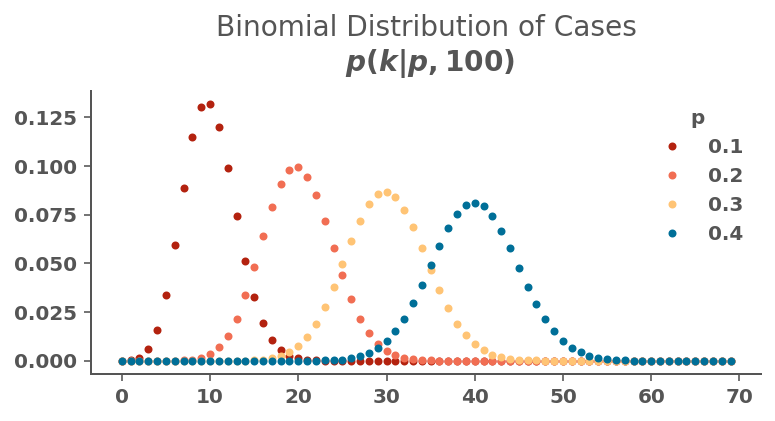

In [7]:
fig, ax = plt.subplots(figsize=(6,2.5))

ax.set(title='Binomial Distribution of Cases\n $p(k|p, 100)$')

plt.plot(k, y,
         marker='o',
         markersize=3,
         lw=0)

plt.legend(title="p", labels=p);

The Binomial distribution says that if you think that a fraction $p$ of the population is positive on a given day, and you test $n$ individual you'll probably get that $pn$ as many positive results, plus or minus some variation based on chance.

But in our case, we know there have been $k$ cases and $n$ tests and we need to know what value of $p$ is most likely. In order to do this, we fix $k$ and $n$ in place while varying $p$.

For example, imagine we observe $k=20$ new cases as a result of testing $n=100$, and we want to know how likely each $p$ is:

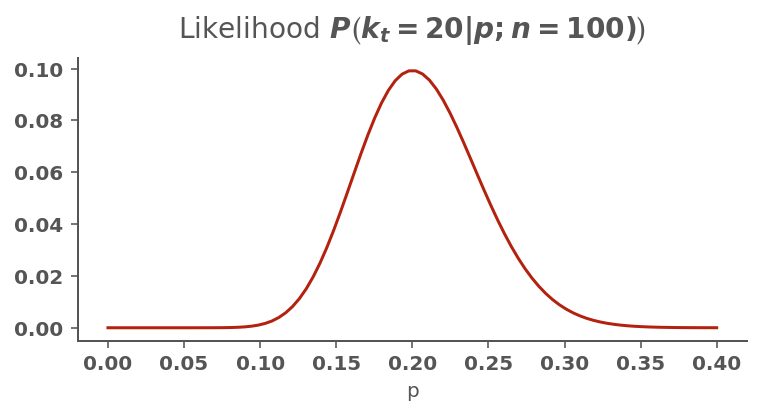

In [11]:
k = 20

p = np.linspace(0, 0.4, 90)

likelihood = pd.Series(data=sps.binom.pmf(k, p=p, n=100),
                       index=pd.Index(p, name='p'),
                       name='p')

likelihood.plot(title=r'Likelihood $P\left(k_t=20|p;n=100)\right)$', figsize=(6,2.5));

This says that if we see 20 cases after sampling 100 individuals, the most likely value of $p$ is (not surprisingly) 0.2. But we're not certain: it's possible p was 0.21 or 0.17 and saw 20 new cases by chance alone. It also says that it's unlikely $p$ was 0.4 and we saw $k=20$ (assuming flat prior).

Great. We have $P\left(p|k_t\right)$ which is parameterized by $p$ but we were looking for $P\left(k_t|R_t\right)$ which is parameterized by $R_t$. We need to know the relationship between $p$, $n$ and $R_t$

### Connecting $p$ and $R_t$

__The key insight to making this work is to realize there's a connection between $R_t$ , $n$ and $p$__. [The derivation](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) is beyond the scope of this notebook, but here it is:

$$ pn = k_{t-1}e^{\gamma(R_t-1)}$$

where $\gamma$ is the reciprocal of the serial interval ([about 7 days for COVID19](https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article)). Since we know every new case and testing count on the previous day, we can now reformulate the likelihood function as a Binomial parameterized by fixing $k$ and varying $R_t$.

$$ p_t = \frac{k_{t-1}}{n_{t-1}}e^{\gamma(R_t-1)}$$

$$P\left(k|R_t\right) = Bi(k;n,p) = {n \choose k} p^k(1-p)^{(n-k)}$$

### Evaluating the Likelihood Function

To continue our example, let's imagine a sample of new case counts $k$. What is the likelihood of different values of $R_t$ on each of those days?

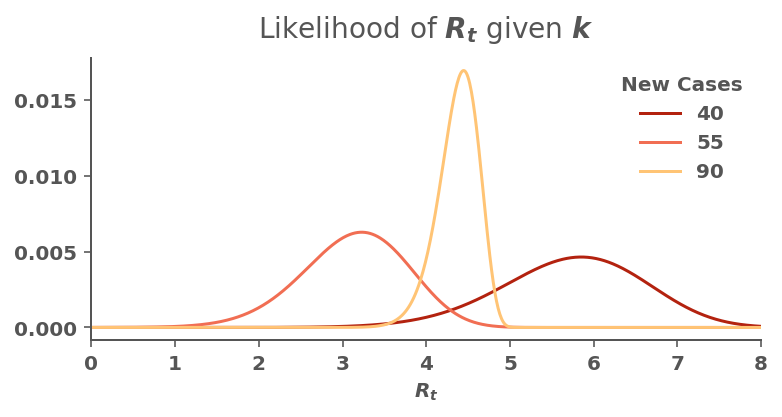

In [249]:
k = np.array([20, 40, 55, 90])
n = np.array([100, 100, 100, 100])
# We create an array for every possible value of Rt
R_T_MAX = 8
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
p = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1)) / n[:-1]

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.binom.pmf(k[1:], p=p, n=n[1:])

# The binomial function yields nan values if the porbabilty is too small, so we replace them with zeros
likelihood_r_t[np.isnan(likelihood_r_t)] = 0

likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

# Plot it
ax = pd.DataFrame(
    data = likelihood_r_t,
    index = r_t_range
).plot(
    title='Likelihood of $R_t$ given $k$',
    xlim=(0,R_T_MAX),
    figsize=(6,2.5)
)

ax.legend(labels=k[1:], title='New Cases')
ax.set_xlabel('$R_t$');

You can see that each day we have a independent guesses for $R_t$. The goal is to combine the information we have about previous days with the current day. To do this, we use Bayes' theorem.

### Performing the Bayesian Update

To perform the Bayesian update, we need to multiply the likelihood by the prior (which is just the previous day's likelihood without our Gaussian update) to get the posteriors. Let's do that using the cumulative product of each successive day:

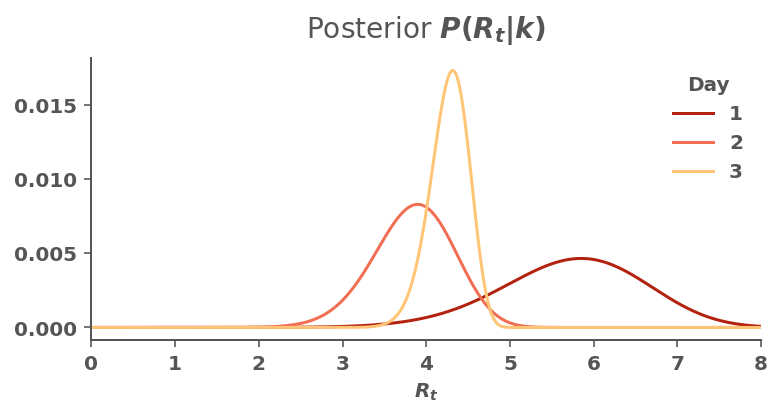

In [250]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

ax = posteriors.plot(
    title='Posterior $P(R_t|k)$',
    xlim=(0,R_T_MAX),
    figsize=(6,2.5)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$');

Notice how on Day 1, our posterior matches Day 1's likelihood from above? That's because we have no information other than that day. However, when we update the prior using Day 2's information, you can see the curve has moved left, but not nearly as left as the likelihood for Day 2 from above. This is because Bayesian updating uses information from both days and effectively averages the two. Since Day 3's likelihood is in between the other two, you see a small shift to the right, but more importantly: a narrower distribution. We're becoming __more__ confident in our believes of the true value of $R_t$.

From these posteriors, we can answer important questions such as "What is the most likely value of $R_t$ each day?"

In [251]:
most_likely_values = posteriors.idxmax(axis=0)
most_likely_values

Day
1    5.85
2    3.90
3    4.32
dtype: float64

We can also obtain the [highest density intervals](https://www.sciencedirect.com/topics/mathematics/highest-density-interval) for $R_t$:

In [252]:
def highest_density_interval(pmf, p=.9, debug=False):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)

    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]

    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

hdi = highest_density_interval(posteriors, debug=True)
hdi.tail()

,Low_90,High_90
Day,,
1,4.27,7.10
2,3.01,4.60
3,3.87,4.63


Finally, we can plot both the most likely values for $R_t$ and the HDIs over time. This is the most useful representation as it shows how our beliefs change with every day.

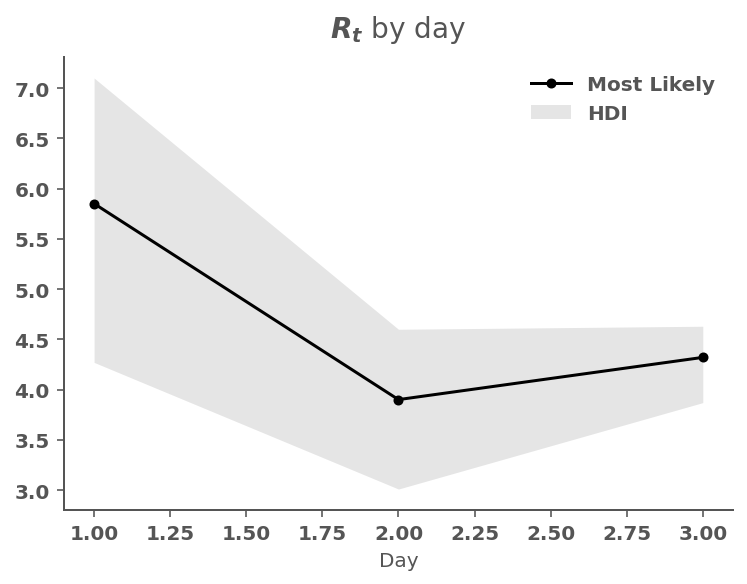

In [253]:
ax = most_likely_values.plot(marker='o',
                             label='Most Likely',
                             title=f'$R_t$ by day',
                             c='k',
                             markersize=4)

ax.fill_between(hdi.index,
                hdi['Low_90'],
                hdi['High_90'],
                color='k',
                alpha=.1,
                lw=0,
                label='HDI')

ax.legend();

We can see that the most likely value of $R_t$ changes with time and the highest-density interval narrows as we become more sure of the true value of $R_t$ over time. Note that since we only had four days of history, I did not apply the process to this sample. Next, however, we'll turn to a real-world application where this process is necessary.

# Real-World Application to US Data

### Setup

Load US state case data from CovidTracking.com

In [302]:
url = 'https://covidtracking.com/api/v1/states/daily.csv'
states = pd.read_csv(url,
                     usecols=['date', 'state', 'positive', 'totalTestResults'],
                     parse_dates=['date'],
                     index_col=['state', 'date'],
                     squeeze=True).sort_index()

Taking a look at the state, we need to start the analysis when there are a consistent number of cases each day. Find the last zero new case day and start on the day after that.

Also, case reporting is very erratic based on testing backlogs, etc. To get the best view of the 'true' data we can, I've applied a gaussian filter to the time series. This is obviously an arbitrary choice, but you'd imagine the real world process is not nearly as stochastic as the actual reporting.

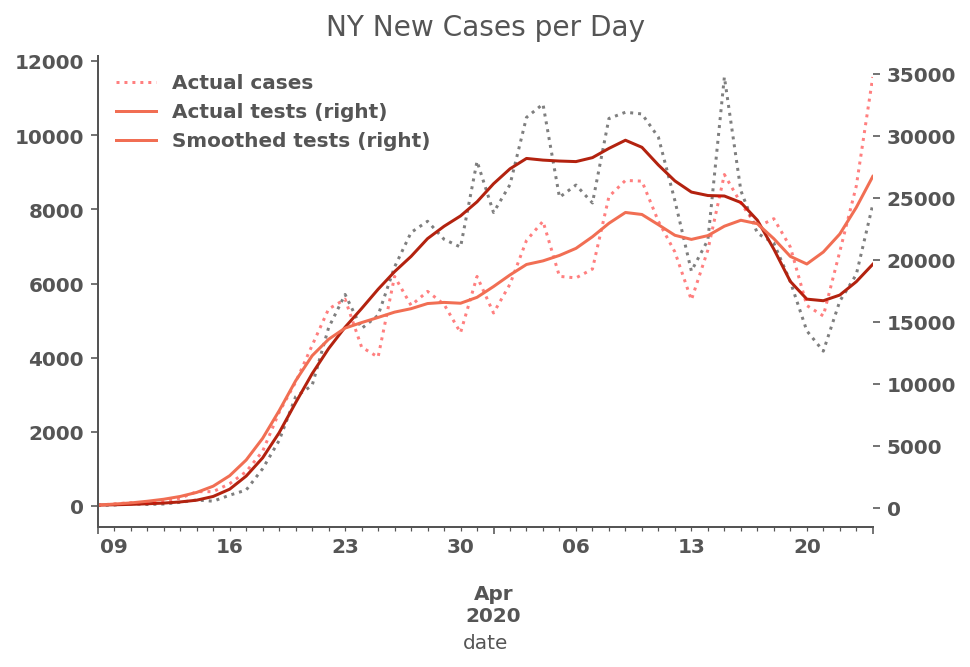

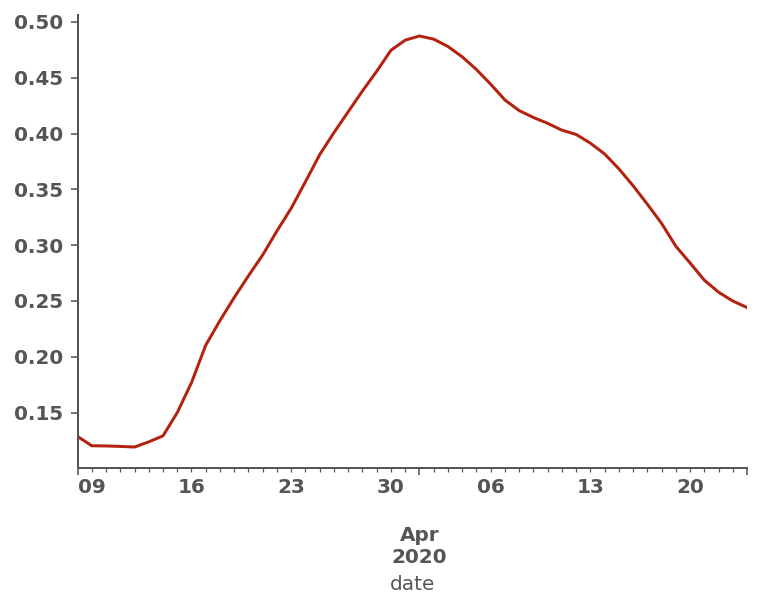

In [361]:
state_name = 'NY'

def prepare_cases(cases, cutoff_cases=25, cutoff_tests=100):
    #new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
   

    idx_start_cases = np.searchsorted(smoothed['cases'], cutoff_cases)
    idx_start_tests = np.searchsorted(smoothed['tests'], cutoff_tests)
    idx_start = max(idx_start_tests, idx_start_cases)
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    return original, smoothed

cases = states.xs(state_name).rename(columns={'positive': 'cases', 'totalTestResults': 'tests'})
new_cases = cases.diff()
new_cases.loc[(cases.index>='2020-03-04') & (cases.index<='2020-04-02'), 'tests'] = [9, 20,92,66,200,307,401, 425,553,762,1290,1293,1936,2907,4553,7698,10124,13087,16029,16812,12952,12142,18651,16315,17444,16401,14115,18648,15701,18031]
new_cases.loc[(cases.index>='2020-03-04') & (cases.index<='2020-03-29'), 'cases'] = [0, 2, 22, 11,24,28,63,44,56,102,164,131,294,432,1009,1769,2950,3254,4812, 5707,4790,5145,6448,7379,7681,7195]

original, smoothed = prepare_cases(new_cases, cutoff_cases=25, cutoff_tests=25)

ax = original['cases'].plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual cases',
               legend=True,
               figsize=(500/72, 300/72))

ax = original['tests'].plot(c='r',
               linestyle=':',
               alpha=.5,
               label='Actual tests',
               legend=True,
               secondary_y=True, ax=ax)


ax = smoothed['cases'].plot(label='Smoothed cases',
                   legend=True, ax=ax)
ax = smoothed['tests'].plot(label='Smoothed tests',
                   legend=True, ax=ax, secondary_y=True)

ax.get_figure().set_facecolor('w')


smoothed['ratio'] = smoothed['cases'] / smoothed['tests']
smoothed['ratioRatio'] = smoothed['ratio'] / smoothed['ratio'].shift(1)
plt.figure()
smoothed['ratio'].plot()


### Running the Algorithm

#### Choosing the Gaussian $\sigma$ for $P(R_t|R_{t-1})$

> Note: you can safely skip this section if you trust that we chose the right value of $\sigma$ for the process below. Otherwise, read on.

The original approach simply selects yesterday's posterior as today's prior. While intuitive, doing so doesn't allow for our belief that the value of $R_t$ has likely changed from yesterday. To allow for that change, we apply Gaussian noise to the prior distribution with some standard deviation $\sigma$. The higher $\sigma$ the more noise and the more we will expect the value of $R_t$ to drift each day. Interestingly, applying noise on noise iteratively means that there will be a natural decay of distant posteriors. This approach has a similar effect of windowing, but is more robust and doesn't arbitrarily forget posteriors after a certain time like my previous approach. Specifically, windowing computed a fixed $R_t$ at each time $t$ that explained the surrounding $w$ days of cases, while the new approach computes a series of $R_t$ values that explains all the cases, assuming that $R_t$ fluctuates by about $\sigma$ each day.

However, there's still an arbitrary choice: what should $\sigma$ be? Adam Lerer pointed out that we can use the process of maximum likelihood to inform our choice. Here's how it works:

Maximum likelihood says that we'd like to choose a $\sigma$ that maximizes the likelihood of seeing our data $k$: $P(k|\sigma)$. Since $\sigma$ is a fixed value, let's leave it out of the notation, so we're trying to maximize $P(k)$ over all choices of $\sigma$.

Since $P(k)=P(k_0,k_1,\ldots,k_t)=P(k_0)P(k_1)\ldots P(k_t)$ we need to define $P(k_t)$. It turns out this is the denominator of Bayes rule:

$$P(R_t|k_t) = \frac{P(k_t|R_t)P(R_t)}{P(k_t)}$$

To calculate it, we notice that the numerator is actually just the joint distribution of $k$ and $R$:

$$ P(k_t,R_t) =  P(k_t|R_t)P(R_t) $$

We can marginalize the distribution over $R_t$ to get $P(k_t)$:

$$ P(k_t) = \sum_{R_{t}}{P(k_t|R_t)P(R_t)} $$

So, if we sum the distribution of the numerator over all values of $R_t$, we get $P(k_t)$. And since we're calculating that anyway as we're calculating the posterior, we'll just keep track of it separately.

Since we're looking for the value of $\sigma$ that maximizes $P(k)$ overall, we actually want to maximize: 

$$\prod_{t,i}{p(k_{ti})}$$

where $t$ are all times and $i$ is each state.

Since we're multiplying lots of tiny probabilities together, it can be easier (and less error-prone) to take the $\log$ of the values and add them together. Remember that $\log{ab}=\log{a}+\log{b}$. And since logarithms are monotonically increasing, maximizing the sum of the $\log$ of the probabilities is the same as maximizing the product of the non-logarithmic probabilities for any choice of $\sigma$.

### Function for Calculating the Posteriors

To calculate the posteriors we follow these steps:
1. Calculate $\lambda$ - the expected arrival rate for every day's poisson process
2. Calculate each day's likelihood distribution over all possible values of $R_t$
3. Calculate the process matrix based on the value of $\sigma$ we discussed above
4. Calculate our initial prior because our first day does not have a previous day from which to take the posterior
  - Based on [info from the cdc](https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article) we will choose a Gamma with mean 7.
5. Loop from day 1 to the end, doing the following:
  - Calculate the prior by applying the Gaussian to yesterday's prior.
  - Apply Bayes' rule by multiplying this prior and the likelihood we calculated in step 2.
  - Divide by the probability of the data (also Bayes' rule)

In [362]:
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)
#r_t_range = np.concatenate([[-10**(0)], r_t_range])
def get_posteriors(sr, sigma=0.15):
    
    
    # (1) Calculate p
    p = sr['cases'].values[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1)) / sr['tests'].values[:-1]
    
    
    #lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.binom.pmf(sr['cases'].values[1:], p=p, n=sr['tests'].values[1:]), #sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    likelihoods[likelihoods.isna()] = 0
    print(p.shape, sr.shape, likelihoods.shape)
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)

    # (4) Calculate the initial prior
    #prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 = np.ones_like(r_t_range)/len(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]

        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator

        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood, likelihoods

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood, likelihoods = get_posteriors(smoothed, sigma=0.25)

(1201, 47) (48, 4) (1201, 47)


### The Result

Below you can see every day (row) of the posterior distribution plotted simultaneously. The posteriors start without much confidence (wide) and become progressively more confident (narrower) about the true value of $R_t$

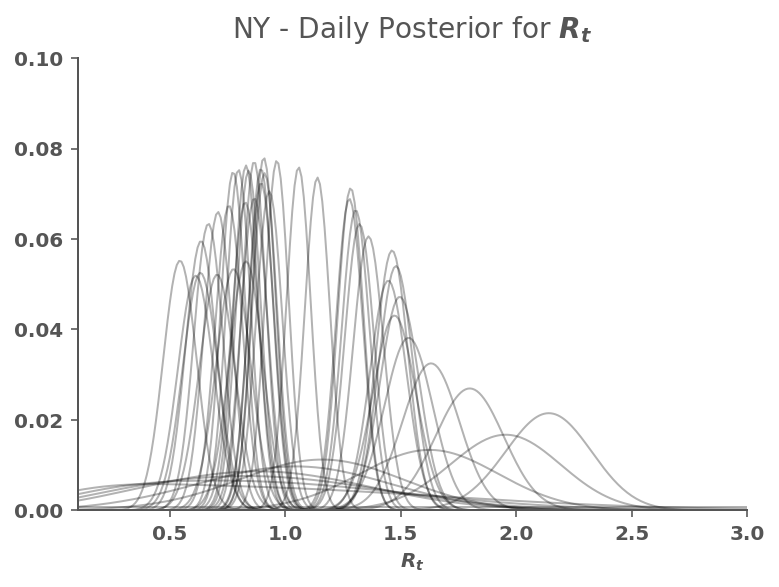

In [363]:
ax = posteriors.plot(title=f'{state_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.1,3), ylim=(0, 0.1))

ax.set_xlabel('$R_t$');

In [364]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1).iloc[1:]

result.tail()

,ML,Low_90,High_90
date,,,
2020-04-20,0.63,0.50,0.75
2020-04-21,0.61,0.46,0.72
2020-04-22,0.70,0.55,0.81
2020-04-23,0.78,0.64,0.89
2020-04-24,0.83,0.70,0.94


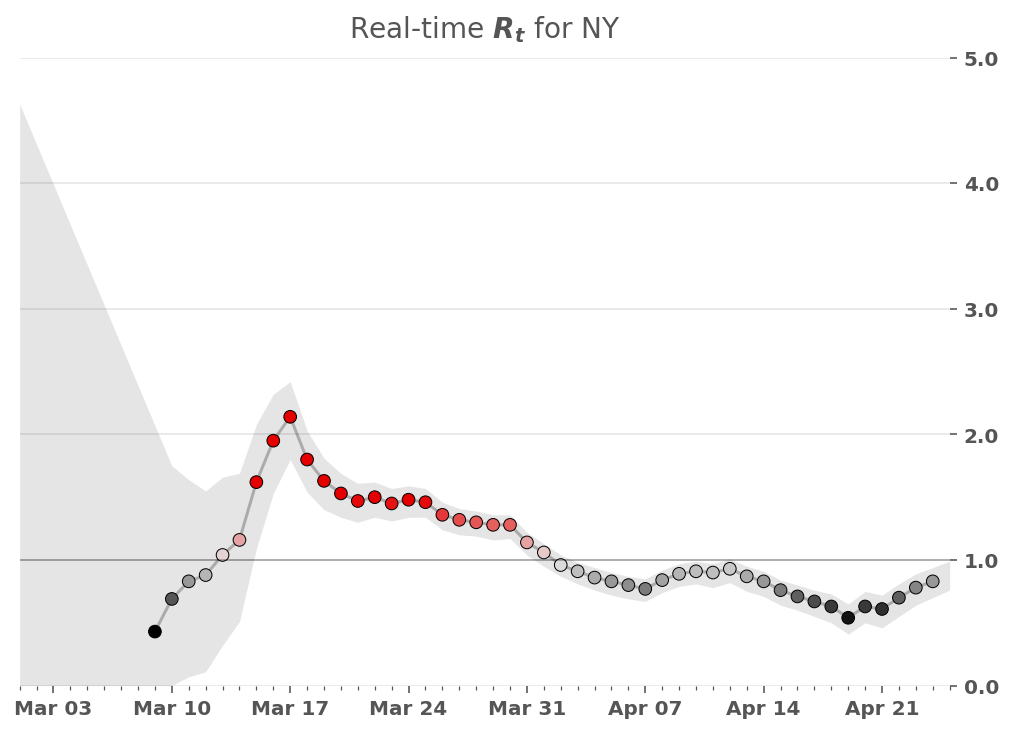

In [365]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
pepe = smoothed['cases']/ smoothed['tests']
